In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
import InsanallyLabEphysTools as ilep
import OldDecodingTools as odt
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from itertools import product
from datetime import datetime
from matplotlib.backends.backend_pdf import PdfPages
import h5py
#import tables as tb
from copy import deepcopy
import colorsys
import pingouin as pg

from sklearn.model_selection import GridSearchCV, StratifiedKFold, LeaveOneOut
from sklearn.neighbors import KernelDensity

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.weight'] = 'light'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
SWITCH_COLOR = '#B07A3B'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']

act_directory = 'D:\\Analysis_Cache'
ops_directory = 'D:\\Opsin_Cache'
beh_directory = 'P:\\Behavioor'

%run animal_info
ANIMAL = 'AC_12102016'

#animalstouse = ['BS_40','BS_41','BS_42','BS_49','BS_51','BS_56','BS_59','BS_61','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']

dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_61','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']
opsinanimalnames = ['BS_86','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165','BS_174','BS_179','BS_191','BS_192']
tuninganimalnames = ['BS_173','BS_175','BS_187','BS_188','BS_213','BS_214','TH_217','AE_235','AE_236','TH_237']
unuseddualanimals = ['BS_78']

dualanimals = ['BS_174','BS_179','BS_191','BS_192']
retroanimals = ['PB_86','BS_86','PB_92','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165']
didlearnopsinanimals = ['BS_92','BS_103','BS_111','BS_179']
didnotlearnopsinanimals = ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']
indeterminateopsinanimals = ['BS_139','BS_165','BS_191','BS_192']

In [2]:
animals_in_cache = []
for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    animals_in_cache.append(sessionfile.meta.animal)
for session in tqdm(os.listdir(ops_directory)):
    sessionfile = ilep.loadSessionCached(ops_directory,session)
    animals_in_cache.append(sessionfile.meta.animal)
animals_in_cache = np.unique(animals_in_cache)

training_days_recorded = dict()
for animal in animals_in_cache:
    training_days_recorded[animal] = []
    
for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if sessionfile.meta.region != 'AC':
        continue
    training_days_recorded[sessionfile.meta.animal].append(sessionfile.meta.day_of_training)
for session in tqdm(os.listdir(ops_directory)):
    sessionfile = ilep.loadSessionCached(ops_directory,session)
    if sessionfile.meta.region != 'AC':
        continue
    training_days_recorded[sessionfile.meta.animal].append(sessionfile.meta.day_of_training)
    
print(training_days_recorded['BS_59'])

100%|██████████| 101/101 [00:00<00:00, 302.94it/s]

[]


In [3]:
firstExpert = SimpleNamespace()
firstExpert.pre = dict()
firstExpert.post = dict()

#Tuning Animals
firstExpert.pre['BS_173'] = 14
firstExpert.pre['BS_175'] = 10
firstExpert.pre['BS_187'] = 6
firstExpert.pre['BS_188'] = 5
firstExpert.pre['BS_213'] = 6
firstExpert.pre['BS_214'] = np.Inf
firstExpert.pre['TH_217'] = 18
firstExpert.pre['AE_235'] = 8
firstExpert.pre['AE_236'] = 9
firstExpert.pre['TH_237'] = 7

firstExpert.post['BS_173'] = 28
firstExpert.post['BS_175'] = 27
firstExpert.post['BS_187'] = 15
firstExpert.post['BS_188'] = 18
firstExpert.post['BS_213'] = np.Inf
firstExpert.post['BS_214'] = np.Inf
firstExpert.post['TH_217'] = np.Inf ### Pending
firstExpert.post['AE_235'] = np.Inf ### Pending
firstExpert.post['AE_236'] = np.Inf ### Pending
firstExpert.post['TH_237'] = np.Inf ### Pending

#Dual recording animals
firstExpert.pre['BS_40'] = 16 # Maybe 17
firstExpert.pre['BS_41'] = 4
firstExpert.pre['BS_42'] = 5
firstExpert.pre['BS_49'] = 12
firstExpert.pre['BS_50'] = 10
firstExpert.pre['BS_51'] = 6
firstExpert.pre['BS_56'] = 6
firstExpert.pre['BS_59'] = 4
firstExpert.pre['BS_67'] = 4 #Maybe 5. 68% and 1.6
firstExpert.pre['BS_70'] = 6
firstExpert.pre['BS_72'] = 4
firstExpert.pre['BS_87'] = 4
firstExpert.pre['BS_108'] = 5
firstExpert.pre['DS_15'] = 9
firstExpert.pre['DS_19'] = 10

firstExpert.post['BS_40'] = 30
firstExpert.post['BS_41'] = 16
firstExpert.post['BS_42'] = 15
firstExpert.post['BS_49'] = 18
firstExpert.post['BS_50'] = np.Inf
firstExpert.post['BS_51'] = 17
firstExpert.post['BS_56'] = 14
firstExpert.post['BS_59'] = 13
firstExpert.post['BS_67'] = 13
firstExpert.post['BS_70'] = 18
firstExpert.post['BS_72'] = 19
firstExpert.post['BS_87'] = 13
firstExpert.post['BS_108'] = 15
firstExpert.post['DS_15'] = 25 #Double-check this
firstExpert.post['DS_19'] = 23

In [4]:
#dualnames = ['BS_108','BS_113','BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_70','BS_72','BS_83','BS_85','BS_87','BS_95']
#animalnames = dualnames

#Animals missing:
#113,50,83,95
#Animals added:
#61,67,15,16,17,19,22

#animalnames = ['BS_40','BS_41','BS_42','BS_49','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']
dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']
opsinanimalnames = ['BS_86','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165','BS_174','BS_179','BS_191','BS_192']
tuninganimalnames = ['BS_173','BS_175','BS_187','BS_188','BS_213','BS_214','TH_217','AE_235','AE_236','TH_237']
unuseddualanimals = ['BS_78']

animalnames = np.concatenate([dualanimalnames,opsinanimalnames,tuninganimalnames,unuseddualanimals])

animals = dict()
for animal in animalnames:
    animals[animal] = SimpleNamespace()
    animals[animal].name = animal
    
#Dual Recording Animals
#animals['BS_33'].reversal = 20
animals['BS_67'].reversal = 7
#animals['BS_73'].reversal = np.nan
animals['BS_78'].reversal = np.nan
animals['BS_108'].reversal = 7
#animals['BS_113'].reversal = 13
animals['BS_40'].reversal = 18
animals['BS_41'].reversal = 6
animals['BS_42'].reversal = 7
animals['BS_49'].reversal = 13
animals['BS_50'].reversal = 12
animals['BS_51'].reversal = 8
#animals['BS_52'].reversal = 15
animals['BS_56'].reversal = 8
animals['BS_59'].reversal = 7
#animals['BS_61'].reversal = 9    ###
animals['BS_70'].reversal = 8
animals['BS_72'].reversal = 6
#animals['BS_83'].reversal = 20
#animals['BS_85'].reversal = 10
animals['BS_87'].reversal = 6
#animals['DS_16'].reversal = 11
#animals['BS_95'].reversal = 8
animals['DS_15'].reversal = 12
animals['DS_19'].reversal = 12

#Opsin Animals
animals['BS_86'].reversal = 14
animals['BS_92'].reversal = 9
animals['BS_100'].reversal = 11
animals['BS_103'].reversal = 8
animals['BS_111'].reversal = 8
animals['BS_119'].reversal = 10
animals['BS_123'].reversal = 9
animals['BS_128'].reversal = 6
animals['BS_131'].reversal = 14
animals['BS_139'].reversal = 10
animals['BS_163'].reversal = 13
animals['BS_165'].reversal = np.Inf
animals['BS_174'].reversal = 14
animals['BS_179'].reversal = 16
animals['BS_191'].reversal = 10
animals['BS_192'].reversal = 7

#Tuning Animals
animals['BS_173'].reversal = 15
animals['BS_175'].reversal = 11
animals['BS_187'].reversal = 8
animals['BS_188'].reversal = 8
animals['BS_213'].reversal = 8
animals['BS_214'].reversal = np.Inf
animals['TH_217'].reversal = 20
animals['AE_235'].reversal = np.Inf ### Pending
animals['AE_236'].reversal = np.Inf ### Pending
animals['TH_237'].reversal = np.Inf ### Pending

print([a for a in animals])

['BS_40', 'BS_41', 'BS_42', 'BS_49', 'BS_50', 'BS_51', 'BS_56', 'BS_59', 'BS_67', 'BS_70', 'BS_72', 'BS_87', 'BS_108', 'DS_15', 'DS_19', 'BS_86', 'BS_92', 'BS_100', 'BS_103', 'BS_111', 'BS_119', 'BS_123', 'BS_128', 'BS_131', 'BS_139', 'BS_163', 'BS_165', 'BS_174', 'BS_179', 'BS_191', 'BS_192', 'BS_173', 'BS_175', 'BS_187', 'BS_188', 'BS_213', 'BS_214', 'TH_217', 'AE_235', 'AE_236', 'TH_237', 'BS_78']


BS_40
6
BS_41
3
BS_42
3
BS_49
2
BS_50
7
BS_51
6
BS_56
4
BS_59
3
BS_67
4
BS_70
5
BS_72
3
BS_87
4
BS_108
3
DS_15
7
DS_19
4
BS_86
7
BS_92
4
BS_100
3
BS_103
4
BS_111
4
BS_119
5
BS_123
3
BS_128
3
BS_131
5
BS_139
6
BS_163
3
BS_165
BS_165 has no post-reversal
3
BS_174
2
BS_179
8
BS_191
BS_191 has no post-reversal
3
BS_192
6
BS_173
2
BS_175
1
BS_187
4
BS_188
5
BS_213
6
BS_214
BS_214 has no post-reversal
inf
TH_217
TH_217 has no post-reversal
10
AE_235
AE_235 has no post-reversal
4
AE_236
AE_236 has no post-reversal
5
TH_237
TH_237 has no post-reversal
7
BS_78
BS_78 has no post-reversal
inf


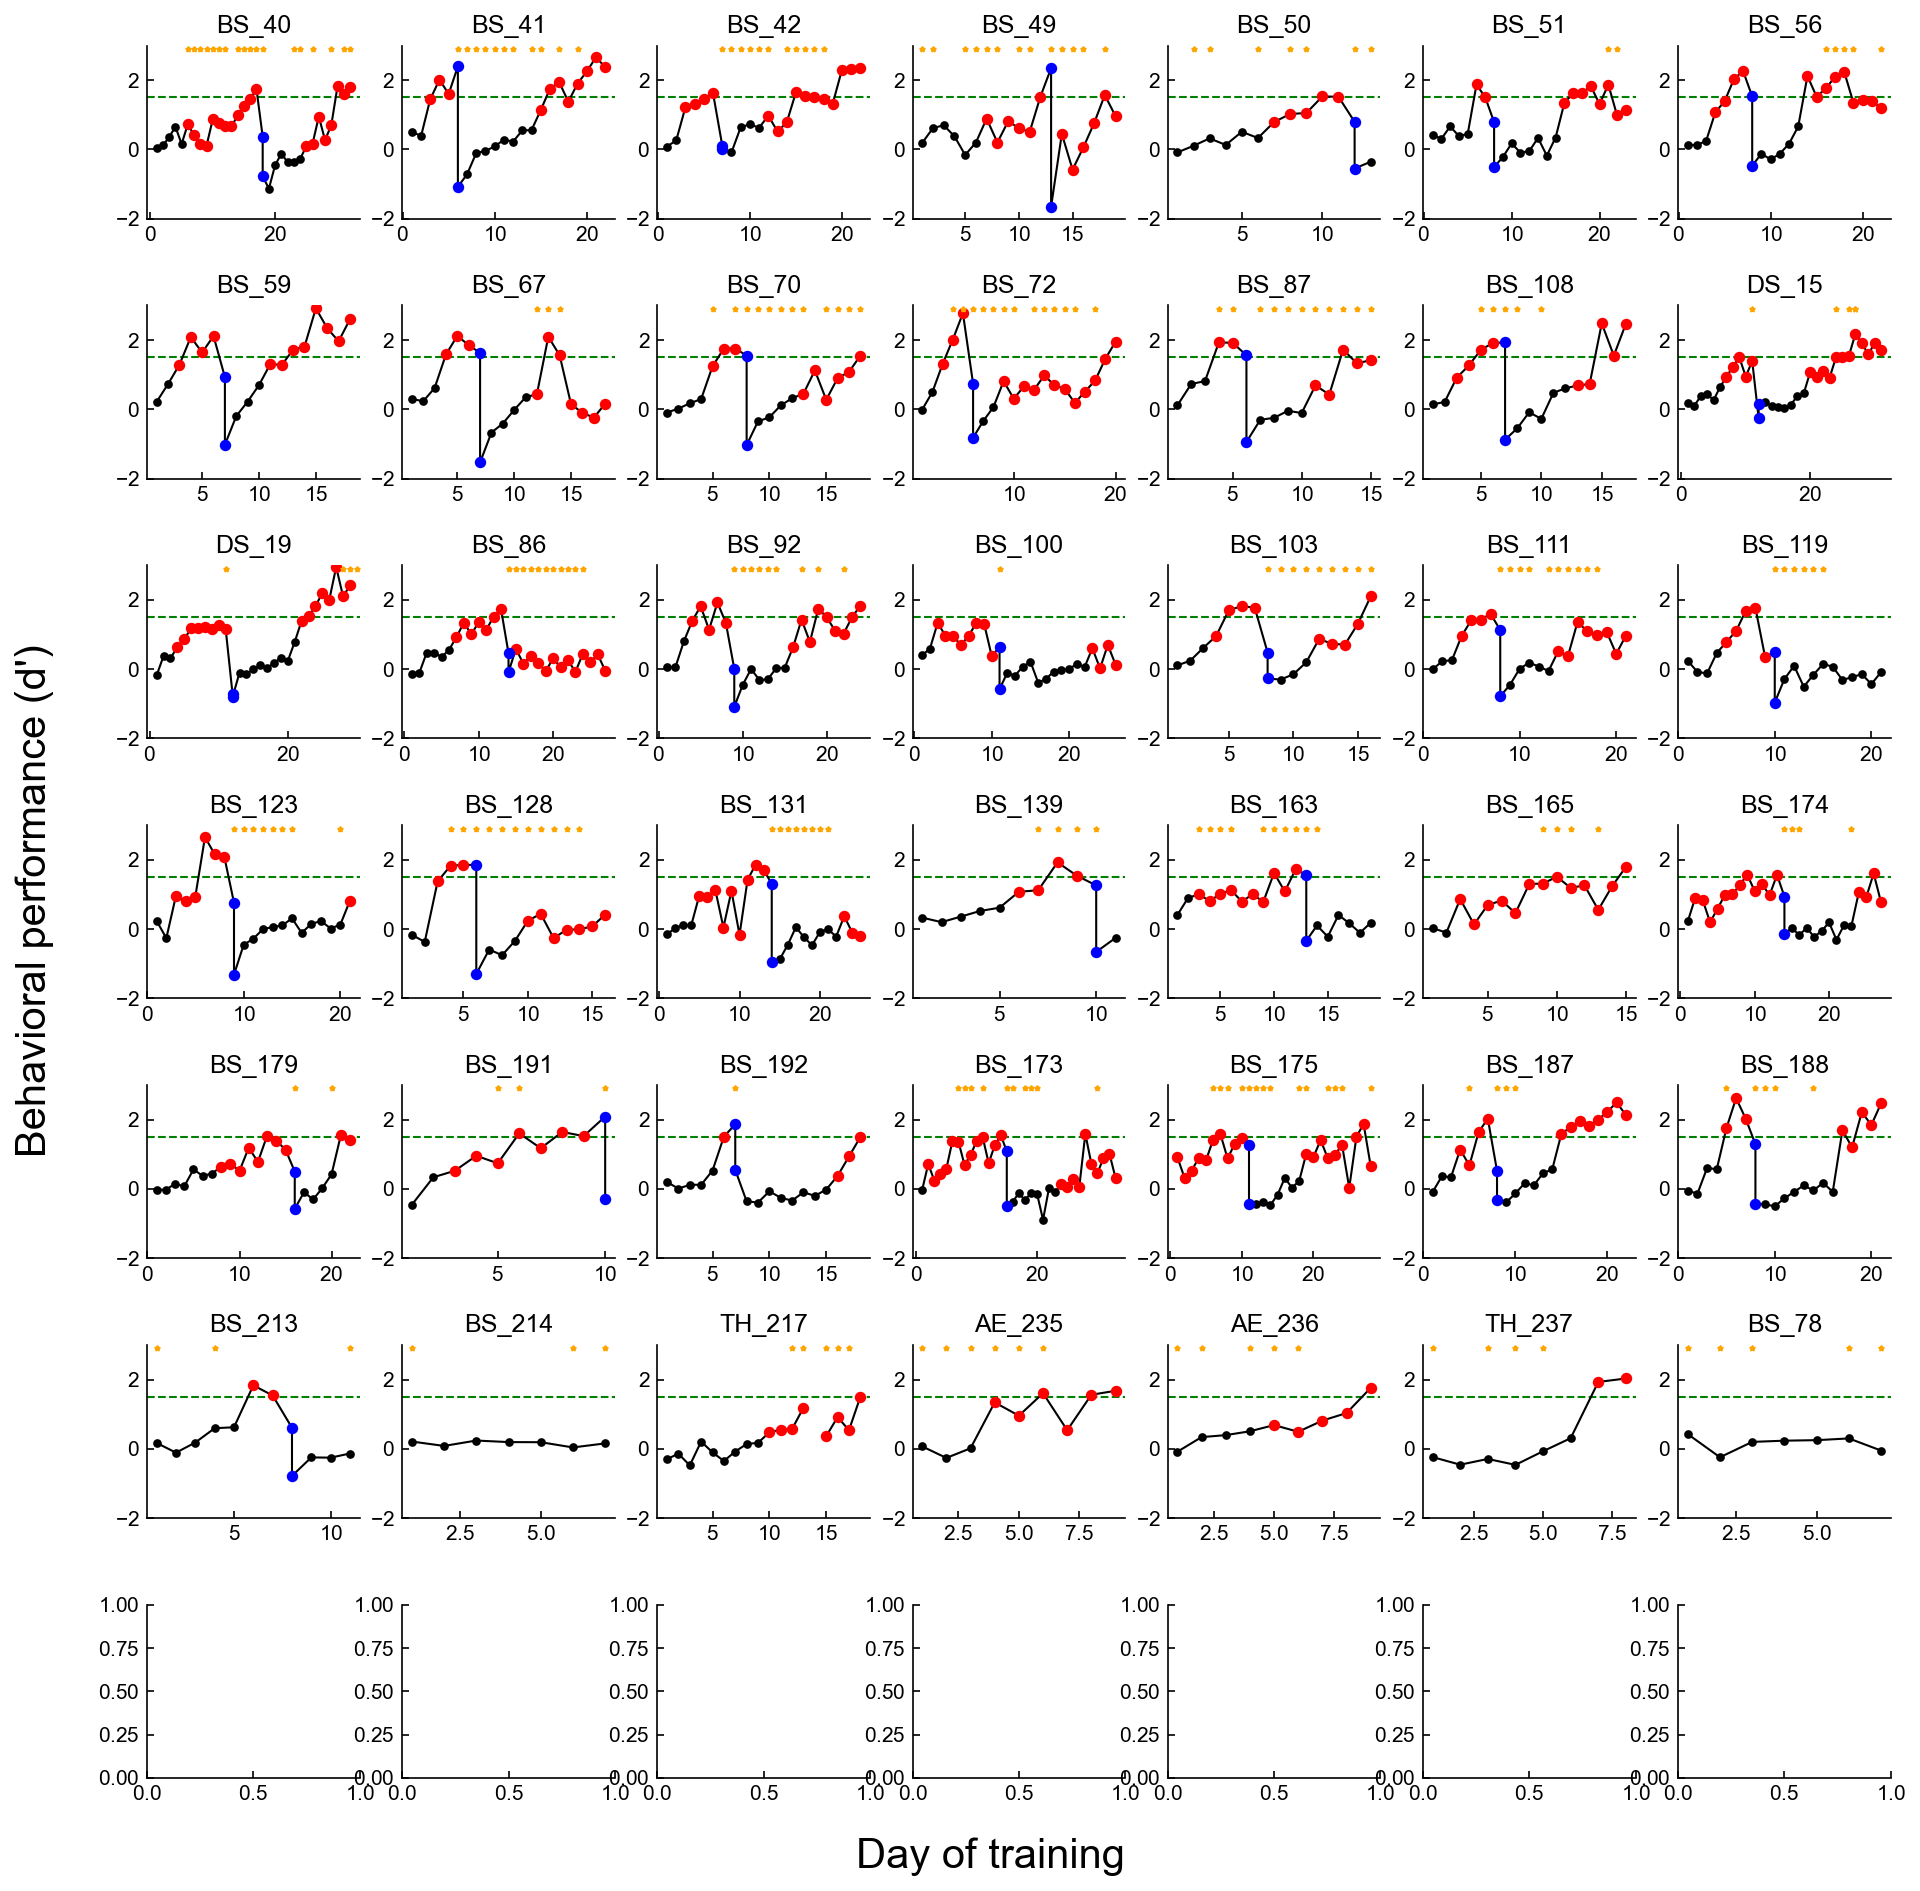

In [5]:
#filename = os.path.join('C:\\\\Users','insan','Desktop','DataForJMTTotal.csv')
filename = os.path.join('D:\\\\DataForJMTTotal.csv')
csv = pd.read_csv(filename)

postthresholds = dict()

plot=True
if plot:
    fig = plt.figure(figsize=(15,15))
    gs = fig.add_gridspec(7,7,hspace=0.5)
    axs = [plt.subplot(gs[i,j]) for i,j in product(range(7),range(7))]
    #plt.delaxes(axs[14])
    #plt.delaxes(axs[15])

premiddlecutoffs = dict()
postmiddlecutoffs = dict()
PERphases = dict()

for animalidx,animal in enumerate(animals):
    print(animal)
    PERphases[animal] = dict()
    
    condname = 'd\' ' + animal
    pc_condname = 'Percent correct ' + animal
    days = np.array(list(csv['Day']))
    cond = csv[condname]
    cond_pc = csv[pc_condname]
    
    #Correct for double reversal days
    for idx,day in enumerate(days):
        if day > animals[animal].reversal:
            days[idx] = day-1
            
        if day > animals[animal].reversal+1: #  +1 because the csv stores the switch day as two entries
            #Calculate PERphase
            PC = cond_pc[idx]
            if PC <= 47.5:
                PERphases[animal][day-1] = 'perseveration'
            elif PC >= 52.5:
                PERphases[animal][day-1] = 'refinement'
            else:
                PERphases[animal][day-1] = 'exploration'
            
    #days = days - animals[animal].reversal
    
    prereversaldays = []
    prereversaldps = []
    maxreversaldp = -np.Inf
    minreversaldp = np.Inf
    postreversaldays = []
    postreversaldps = []
    for idx,day in enumerate(days):
        if day < animals[animal].reversal or np.isnan(animals[animal].reversal):
            prereversaldays.append(day)
            prereversaldps.append(cond[idx])
        if day == animals[animal].reversal:
            maxreversaldp = max(cond[idx],maxreversaldp)
            minreversaldp = min(cond[idx],minreversaldp)
        if day > animals[animal].reversal and not np.isnan(cond[idx]):
            postreversaldays.append(day)
            postreversaldps.append(cond[idx])
            
    #Prereversal threshold
    maxperf = np.nanmax(np.concatenate((prereversaldps,[1.5])))
    minperf = np.nanmin(prereversaldps)
    prethreshold = minperf + 0.4*(maxperf-minperf)
    #Postreversal threshold
    try:
        maxperf = np.nanmax(np.concatenate((postreversaldps,[1.5])))
        minperf = np.nanmin(postreversaldps)
    except:
        print(animal+' has no post-reversal')
        maxperf = np.nan
        minperf = np.nan
    postthreshold = minperf + 0.4*(maxperf-minperf)
    
    postthresholds[animal] = postthreshold
    
    prereversaldays = np.array(prereversaldays)
    prereversaldps = np.array(prereversaldps)
    postreversaldays = np.array(postreversaldays)
    postreversaldps = np.array(postreversaldps)
    
    premiddlebool = np.greater_equal(prereversaldps,prethreshold)
    for idx,day in enumerate(prereversaldays):
        if premiddlebool[idx]:
            premiddlebool[idx:(len(premiddlebool)-1)].fill(True)
        #if not premiddlebool[idx]:
        #    premiddlebool[0:idx].fill(False)
    if np.any(premiddlebool):
        premiddlefirstday = np.min(prereversaldays[premiddlebool])
    else:
        premiddlefirstday = np.Inf
        
    print(premiddlefirstday)
                     
    postmiddlebool = np.greater_equal(postreversaldps,postthreshold)
    for idx,day in enumerate(postreversaldays):
        if postmiddlebool[idx]:
            postmiddlebool[idx:(len(postmiddlebool)-1)].fill(True)
        #if not postmiddlebool[idx]:
        #    postmiddlebool[0:idx].fill(False)
    if np.any(postmiddlebool):
        postmiddlefirstday = np.min(postreversaldays[postmiddlebool])
    else:
        postmiddlefirstday = np.Inf
    
    if animal == 'BS_95':
        premiddlefirstday = 4
    if animal == 'BS_49':
        premiddlefirstday = 7
    if animal in ['BS_83','BS_50']:
        postmiddlefirstday = np.Inf
    
    premiddlecutoffs[animal] = premiddlefirstday
    postmiddlecutoffs[animal] = postmiddlefirstday
    
    if plot:
        ax = axs[animalidx]    
        #All Days no color
        ax.plot(days,cond,color='k',lw=1)
        ax.scatter(days,cond,color='k',s=10,zorder=9)
        #Pre Middle
        premiddle = np.logical_and( np.greater_equal(days,premiddlefirstday), np.less(days,animals[animal].reversal) )
        ax.scatter(days[premiddle],cond[premiddle],color='r',s=20,zorder=10)
        #Post Middle
        postmiddle = np.greater_equal(days,postmiddlefirstday)
        ax.scatter(days[postmiddle],cond[postmiddle],color='r',s=20,zorder=10)
        #Switch
        switch = np.equal(days,animals[animal].reversal)
        ax.scatter(days[switch],cond[switch],color='b',s=20,zorder=10)

        xlims = ax.get_xlim()
        ax.plot(xlims,[1.5,1.5],c='g',linestyle='--',lw=1,zorder=-10)
        ax.set_xlim(xlims)
        ax.set_ylim([-2,3])
        
        days_recorded = training_days_recorded[animal]
        ax.scatter(days_recorded,np.ones_like(days_recorded)*2.9,s=5,marker='*',color='orange',zorder=11)

        ax.set_title(animal)
        
fig.text(0.075, 0.5, 'Behavioral performance (d\')', ha='center', va='center', rotation='vertical',fontsize=20)
fig.text(0.5,0.075, 'Day of training', ha='center', va='center', rotation='horizontal',fontsize=20)

if plot:
    #plt.savefig(os.path.join('D:\\\\TempFigures','EIL Learning Phases.pdf'),transparent=False,facecolor="white")
    pass

In [6]:
print('Finished loading')

Finished loading


In [7]:
EnumSession = []
EnumClust = []
sessions = os.listdir(act_directory)
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task in ['passive no beahvior']:
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.region != 'AC':
        continue
        
    if sessionfile.meta.animal not in dualanimalnames:
        continue
    
    for clust in sessionfile.clusters.good:
        EnumSession.append(session)
        EnumClust.append(clust)

100%|██████████| 517/517 [00:02<00:00, 220.47it/s]


In [8]:
regions = np.full_like(EnumSession,np.nan)
for idx,session in enumerate(tqdm(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    regions[idx] = sessionfile.meta.region

100%|██████████| 1440/1440 [00:07<00:00, 180.54it/s]


In [9]:
EILphases = np.full_like(EnumSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and sessionfile.meta.day_of_training < premiddlecutoffs[sessionfile.meta.animal]:
            EILphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and sessionfile.meta.day_of_training < firstExpert.pre[sessionfile.meta.animal] and sessionfile.meta.day_of_training >= premiddlecutoffs[sessionfile.meta.animal]:
            EILphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and sessionfile.meta.day_of_training >= firstExpert.pre[sessionfile.meta.animal]:
            EILphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal'] and sessionfile.meta.day_of_training < postmiddlecutoffs[sessionfile.meta.animal]:
            EILphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal'] and sessionfile.meta.day_of_training < firstExpert.post[sessionfile.meta.animal] and sessionfile.meta.day_of_training >= postmiddlecutoffs[sessionfile.meta.animal]:
            EILphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal'] and sessionfile.meta.day_of_training >= firstExpert.post[sessionfile.meta.animal]:
            EILphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 1440/1440 [00:07<00:00, 180.52it/s]

errors for: []


In [10]:
FRmod_preearly = []
FRmod_prelate = []
FRmod_preexpert = []
FRmod_postearly = []
FRmod_postlate = []
FRmod_postexpert = []

FRb_preearly = []
FRb_prelate = []
FRb_preexpert = []
FRb_postearly = []
FRb_postlate = []
FRb_postexpert = []

FRe_preearly = []
FRe_prelate = []
FRe_preexpert = []
FRe_postearly = []
FRe_postlate = []
FRe_postexpert = []

FReT_preearly = []
FReT_prelate = []
FReT_preexpert = []
FReT_postearly = []
FReT_postlate = []
FReT_postexpert = []

FReNT_preearly = []
FReNT_prelate = []
FReNT_preexpert = []
FReNT_postearly = []
FReNT_postlate = []
FReNT_postexpert = []

FRt_preearly = []
FRt_prelate = []
FRt_preexpert = []
FRt_postearly = []
FRt_postlate = []
FRt_postexpert = []

preearly_animals = []
prelate_animals = []
preexpert_animals = []
postearly_animals = []
postlate_animals = []
postexpert_animals = []

animalstouse = np.concatenate((dualanimalnames,unuseddualanimals,tuninganimalnames))
print(animalstouse)

cellstouseFR = 'all cells'
#cellstouseFR = 'task encoders'

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if not regions[idx] == 'AC':
        continue
    
    #Currently not active as tuning curve animals have not been decoded
    if cellstouseFR == 'task encoders':
        if not np.isfinite(accuracies[idx]) or pvals[idx] > 0.05 or accuracies[idx] < task_encoder_threshold:
            continue
            
    if not sessionfile.meta.animal in animalstouse:
        continue
    if sessionfile.meta.animal in tuninganimalnames:
        continue
    #if sessionfile.meta.animal == 'TH_217':
    #    continue
        
    if sessionfile.meta.animal == 'BS_67' and sessionfile.meta.day_of_training >= 15:
        continue
        
    if sessionfile.meta.animal == 'BS_50' and sessionfile.meta.day_of_training >= 13:
        continue
        
    if sessionfile.meta.animal == 'BS_78' and sessionfile.meta.day_of_training >= 3:
        continue
        
    if sessionfile.meta.animal == 'BS_214' and sessionfile.meta.day_of_training >= 3:
        continue
        
    if sessionfile.responsiveness[clust]['all_trials'].FR < sessionfile.responsiveness[clust]['all_trials'].FRbaseline:
        #print('excluded')
        #continue
        pass
        
    #if not sessionfile.meta.animal in ['BS_213','BS_214']:
    #    continue
    
    #else:
    #    print(ilep.generateDateString(sessionfile))
    #    print(len(sessionfile.clusters.good))
        
    #if np.isnan(accuracies[idx]):
    #    continue
        
    if EILphases[idx] == 'pre early':
        FRb_preearly.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_preearly.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FRmod_preearly.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        FReT_preearly.append(sessionfile.responsiveness[clust]['target_tone'].FR)
        FReNT_preearly.append(sessionfile.responsiveness[clust]['nontarget_tone'].FR)
        #FRt_preearly.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        #temp = ( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )
        FRt_preearly.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )        
        #Dec_preearly.append(accuracies[idx])
        preearly_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre late':
        FRb_prelate.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_prelate.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FRmod_prelate.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        FReT_prelate.append(sessionfile.responsiveness[clust]['target_tone'].FR)
        FReNT_prelate.append(sessionfile.responsiveness[clust]['nontarget_tone'].FR)
        #FRt_preint.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        FRt_prelate.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )                
        #Dec_preint.append(accuracies[idx])
        prelate_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre expert':
        FRb_preexpert.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_preexpert.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FRmod_preexpert.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        FReT_preexpert.append(sessionfile.responsiveness[clust]['target_tone'].FR)
        FReNT_preexpert.append(sessionfile.responsiveness[clust]['nontarget_tone'].FR)
        #FRt_prelate.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        FRt_preexpert.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )
        #Dec_prelate.append(accuracies[idx])
        preexpert_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post early':
        FRb_postearly.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_postearly.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FRmod_postearly.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        FReT_postearly.append(sessionfile.responsiveness[clust]['target_tone'].FR)
        FReNT_postearly.append(sessionfile.responsiveness[clust]['nontarget_tone'].FR)
        #FRt_postearly.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        FRt_postearly.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )
        #Dec_postearly.append(accuracies[idx])
        postearly_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post late':
        FRb_postlate.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_postlate.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FRmod_postlate.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        FReT_postlate.append(sessionfile.responsiveness[clust]['target_tone'].FR)
        FReNT_postlate.append(sessionfile.responsiveness[clust]['nontarget_tone'].FR)
        #FRt_postint.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        FRt_postlate.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )
        #Dec_postint.append(accuracies[idx])
        postlate_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post expert':
        FRb_postexpert.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_postexpert.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FRmod_postexpert.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        FReT_postexpert.append(sessionfile.responsiveness[clust]['target_tone'].FR)
        FReNT_postexpert.append(sessionfile.responsiveness[clust]['nontarget_tone'].FR)
        #FRt_postlate.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        FRt_postexpert.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )
        #Dec_postlate.append(accuracies[idx])
        postexpert_animals.append(sessionfile.meta.animal)
        
FRb_preearly = np.array(FRb_preearly)
FRb_prelate = np.array(FRb_prelate)
FRb_preexpert = np.array(FRb_preexpert)
FRb_postearly = np.array(FRb_postearly)
FRb_postlate = np.array(FRb_postlate)
FRb_postexpert = np.array(FRb_postexpert)

FRe_preearly = np.array(FRe_preearly)
FRe_prelate = np.array(FRe_prelate)
FRe_preexpert = np.array(FRe_preexpert)
FRe_postearly = np.array(FRe_postearly)
FRe_postlate = np.array(FRe_postlate)
FRe_postexpert = np.array(FRe_postexpert)

FRmod_preearly = np.array(FRmod_preearly)
FRmod_prelate = np.array(FRmod_prelate)
FRmod_preexpert = np.array(FRmod_preexpert)
FRmod_postearly = np.array(FRmod_postearly)
FRmod_postlate = np.array(FRmod_postlate)
FRmod_postexpert = np.array(FRmod_postexpert)

FReT_preearly = np.array(FReT_preearly)
FReT_prelate = np.array(FReT_prelate)
FReT_preexpert = np.array(FReT_preexpert)
FReT_postearly = np.array(FReT_postearly)
FReT_postlate = np.array(FReT_postlate)
FReT_postexpert = np.array(FReT_postexpert)

FReNT_preearly = np.array(FReNT_preearly)
FReNT_prelate = np.array(FReNT_prelate)
FReNT_preexpert = np.array(FReNT_preexpert)
FReNT_postearly = np.array(FReNT_postearly)
FReNT_postlate = np.array(FReNT_postlate)
FReNT_postexpert = np.array(FReNT_postexpert)

FRt_preearly = np.array(FRt_preearly)
FRt_prelate = np.array(FRt_prelate)
FRt_preexpert = np.array(FRt_preexpert)
FRt_postearly = np.array(FRt_postearly)
FRt_postlate = np.array(FRt_postlate)
FRt_postexpert = np.array(FRt_postexpert)

#Dec_preearly = np.array(Dec_preearly)
#Dec_preint = np.array(Dec_preint)
#Dec_prelate = np.array(Dec_prelate)
#Dec_postearly = np.array(Dec_postearly)
#Dec_postint = np.array(Dec_postint)
#Dec_postlate = np.array(Dec_postlate)

['BS_40' 'BS_41' 'BS_42' 'BS_49' 'BS_50' 'BS_51' 'BS_56' 'BS_59' 'BS_67'
 'BS_70' 'BS_72' 'BS_87' 'BS_108' 'DS_15' 'DS_19' 'BS_78' 'BS_173'
 'BS_175' 'BS_187' 'BS_188' 'BS_213' 'BS_214' 'TH_217' 'AE_235' 'AE_236'
 'TH_237']


1440it [00:07, 184.89it/s]


In [11]:
#number of animals in each learning phase

preearly_animals = np.unique(preearly_animals)
prelate_animals = np.unique(prelate_animals)
preexpert_animals = np.unique(preexpert_animals)
postearly_animals = np.unique(postearly_animals)
postlate_animals = np.unique(postlate_animals)
postexpert_animals = np.unique(postexpert_animals)

preearly_animals_num = len(preearly_animals)
prelate_animals_num = len(prelate_animals)
preexpert_animals_num = len(preexpert_animals)
postearly_animals_num = len(postearly_animals)
postlate_animals_num = len(postlate_animals)
postexpert_animals_num = len(postexpert_animals)

In [12]:
print('Finished loading')

Finished loading


# FR modulation AC over learning

baseline = 3.5938903863432152
(0.4161503256210212, 0.20040152034258935, 0.20985037312850605)
(0.7313725490196079, 0.0, 0.032030914555603224)
(0.5908292397676609, 0.09943749755789999, 0.12095830378606467)
(0.4946743777942865, 0.15907937595946714, 0.17377696728070008)
(0.7313725490196079, 0.0, 0.032030914555603224)
(0.7313725490196079, 0.0, 0.032030914555603224)


meta NOT subset; don't know how to subset; dropped


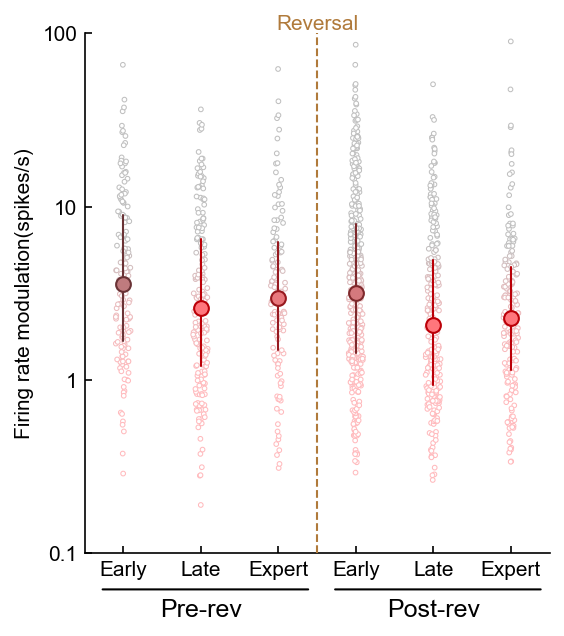

In [22]:
#Firing rate modulation graphs

size=5

FRmod_baseline_median = np.median(FRmod_preearly)
print('baseline = '+str(FRmod_baseline_median))

fig, ax = plt.subplots(figsize=(4,4.5))
data = [FRmod_preearly,FRmod_prelate,FRmod_preexpert,FRmod_postearly,FRmod_postlate,FRmod_postexpert]
#num_animal = [preearly_animal_num,prelate_animal_num,preexpert_animal_num,postearly_animal_num,postlate_animal_num,postexpert_animal_num]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.25)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.25)
colors = NCR_CR_cmap((Y-1)/5)

ax.scatter(X, Y, s=size, ec=colors, fc='white', lw=0.5,zorder=-10)
ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(data):
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color=NCR_CR_cmap((percentCR-40)/20)
    
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    print(border_color)

    summary_size=50
    summary_width=1
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    
    ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
#
ax.set_ylim([0.1,100])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ax.set_ylabel('Firing rate modulation(spikes/s)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

# #numbers
#cells
# for idx,column in enumerate(data):
#     ax.text(idx,120,str(len(column)))
# #animals
# for idx,column in enumerate(num_animal):
#     ax.text(idx,95,str(column))
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.5,zorder=-5)
#ax.axhline(FRmod_baseline_median,color='k',linestyle='--',lw=1,zorder=-4)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')
#statistics
#ax.text(1,105,str('n.s.'))
#ax.text(2,105,str('n.s.'))
#ax.text(3,105,str('n.s.'))
#ax.text(4,105,str('n.s.'))
#ax.text(5,105,str('n.s.'))

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
rev_title_y_pos = -0.055 #0.1 * (ax.get_ylim()[1] - ax.get_ylim()[0])
ax.text(xtick_pos_pre, -rev_title_y_pos, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, -rev_title_y_pos, 'Post-rev', ha='center', va='top',  fontsize=12)
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

fig.savefig(os.path.join('D:\\\\Figures','Decoding Figures','FR modulations','AC FRmodulation all cells over learning V2.pdf'),transparent=False,facecolor="white")

# FR modulation vs Passive

Step 1: Ensure that FRmod_preearly and such are calculated and in memory (using the cells earlier in this notebook)

The following code comes from TH's Passive no behavior notebook. It is unchanged from that notebook as of 2/24/2023

In [25]:
animals_in_cache = []

EnumACSession = []
EnumACClust = []

for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.animal not in ['TH_201','TH_203','LA_204','LA_205','TH_200', 'TH_230','AE_229','TH_233','TH_234']:
        continue
    
    animals_in_cache.append(sessionfile.meta.animal)
    
    for clust in sessionfile.clusters.good:
        if sessionfile.meta.region == "AC":
            EnumACSession.append(session)
            EnumACClust.append(clust)
        
animals_in_cache = np.unique(animals_in_cache)

100%|██████████| 517/517 [00:02<00:00, 216.95it/s]


In [26]:
#Define 6 learning phases(days)
pre_early = 4
pre_late = 6
pre_expert = 8
post_early = 12
post_late = 15
post_expert = 16

#
FRmod_passive_preearly = []
FRmod_passive_prelate = []
FRmod_passive_preexpert = []
FRmod_passive_postearly = []
FRmod_passive_postlate = []
FRmod_passive_postexpert = []

#
preexpert_session_num = []
postlate_session_num = []
postexpert_session_num = []


In [27]:
preearly_passive_animal = []
prelate_passive_animal = []
preexpert_passive_animal = []
postearly_passive_animal = []
postlate_passive_animal = []
postexpert_passive_animal = []


for idx,(session,clust) in tqdm(enumerate(zip(EnumACSession,EnumACClust))):
    ACsessionfile = ilep.loadSessionCached(act_directory,session)
    
    #1,2,3,4
    if ACsessionfile.meta.day_of_training <= pre_early:
        FRmod_passive_preearly.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        preearly_passive_animal.append(ACsessionfile.meta.animal)
        
        
    #5,6
    if ACsessionfile.meta.day_of_training <= pre_late and ACsessionfile.meta.day_of_training >pre_early:
        FRmod_passive_prelate.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        prelate_passive_animal.append(ACsessionfile.meta.animal)
    
    #7,8
    if ACsessionfile.meta.day_of_training <= pre_expert and ACsessionfile.meta.day_of_training >pre_late:
        FRmod_passive_preexpert.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        preexpert_session_num.append(ACsessionfile.meta.files)
        preexpert_passive_animal.append(ACsessionfile.meta.animal)
        
    #9,10,11,12
    if ACsessionfile.meta.day_of_training <= post_early and ACsessionfile.meta.day_of_training >pre_expert:
        FRmod_passive_postearly.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        postearly_passive_animal.append(ACsessionfile.meta.animal)

    #13,14,15
    if ACsessionfile.meta.day_of_training <= post_late and ACsessionfile.meta.day_of_training >post_early:
        FRmod_passive_postlate.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        postlate_session_num.append(ACsessionfile.meta.files)
        postlate_passive_animal.append(ACsessionfile.meta.animal)
    
    #16,17,18,19,20,21
    if ACsessionfile.meta.day_of_training >= post_expert:
        FRmod_passive_postexpert.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        postexpert_session_num.append(ACsessionfile.meta.files)
        postexpert_passive_animal.append(ACsessionfile.meta.animal)
    

1442it [00:11, 129.49it/s]


In [28]:
#number of animals in each learning phase

preearly_passive_animal = np.unique(preearly_passive_animal)
prelate_passive_animal = np.unique(prelate_passive_animal)
preexpert_passive_animal = np.unique(preexpert_passive_animal)
postearly_passive_animal = np.unique(postearly_passive_animal)
postlate_passive_animal = np.unique(postlate_passive_animal)
postexpert_passive_animal = np.unique(postexpert_passive_animal)

preearly_passive_animal_num = len(preearly_passive_animal)
prelate_passive_animal_num = len(prelate_passive_animal)
preexpert_passive_animal_num = len(preexpert_passive_animal)
postearly_passive_animal_num = len(postearly_passive_animal)
postlate_passive_animal_num = len(postlate_passive_animal)
postexpert_passive_animal_num = len(postexpert_passive_animal)

In [29]:
FRmod_passive_preearly = np.array(FRmod_passive_preearly)
FRmod_passive_prelate = np.array(FRmod_passive_prelate)
FRmod_passive_preexpert = np.array(FRmod_passive_preexpert)
FRmod_passive_postearly = np.array(FRmod_passive_postearly)
FRmod_passive_postlate = np.array(FRmod_passive_postlate)
FRmod_passive_postexpert = np.array(FRmod_passive_postexpert)

The following is to be considered from this notebook. It will integrate the data from the behaving animals and the passive animals to compare them

# Log(FRmodulation) Active vs Passive

#DEB9E0
#B78AB9
#906D92
#ABC5E8
#869BB7
#5E6C80
0.03030135981102897
0.02339347283150953
0.727702597919424
0.9197094346077666
1.7975751033758136e-08
1.2023072486780815e-08
0.008333333333333333


meta NOT subset; don't know how to subset; dropped


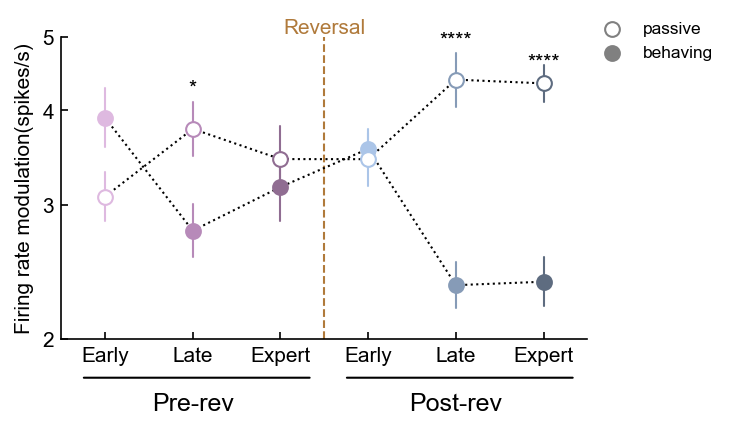

In [92]:
#Firing rate modulation graphs

size=5

FRmod_baseline_median = 3.4986225895316823#np.median(FRmod_preearly)
labels = ['Early','Late','Expert','Early','Late','Expert']
offset_distance = 0#0.05

fig, ax = plt.subplots(figsize=(5,3))

data = [FRmod_preearly,FRmod_prelate,FRmod_preexpert,FRmod_postearly,FRmod_postlate,FRmod_postexpert]
data = [np.log10(d) for d in data]
num_animals = [preearly_animals_num,prelate_animals_num,preexpert_animals_num,postearly_animals_num,postlate_animals_num,postexpert_animals_num]
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.25)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.25)
colors = NCR_CR_cmap((Y-1)/5)

#ax.scatter(X-0.125, Y, s=size, ec=colors, fc='white', lw=0.5,zorder=-10)
#ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(data):
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    #eye_color=NCR_CR_cmap((percentCR-40)/20)
    eye_color = PHASE_COLORS[idx]
    
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=eye_color#colorsys.hls_to_rgb(h,l*0.5,s)
    
    #eye_color='k'
    #border_color='k'

    summary_size=50
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    
    ax.scatter([idx-offset_distance], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx-offset_distance, idx-offset_distance], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    #ax.plot([idx-offset_distance-0.05, idx-offset_distance+0.05], [Q1, Q1], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    #ax.plot([idx-offset_distance-0.05, idx-offset_distance+0.05], [Q3, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
medians = [np.mean(col) for col in data]
plt.plot(np.linspace(0,5,6)-offset_distance,medians,color='k',linestyle=':',lw=1)
    
######################################################################################################################################################
passive_data = [FRmod_passive_preearly,FRmod_passive_prelate,FRmod_passive_preexpert,FRmod_passive_postearly,FRmod_passive_postlate,FRmod_passive_postexpert]
passive_data = [np.log10(d) for d in passive_data]
num_passive_animal = [preearly_passive_animal_num,prelate_passive_animal_num,preexpert_passive_animal_num,postearly_passive_animal_num,postlate_passive_animal_num,postexpert_passive_animal_num]
X = [np.ones(len(l))*idx for idx,l in enumerate(passive_data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(passive_data),width=0.25)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(passive_data)),width=0.25)
colors = NCR_CR_cmap((Y-1)/5)

#ax.scatter(X+0.125, Y, s=size, ec=colors, fc='white', lw=0.5,zorder=-10,marker='s')
#ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(passive_data):
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    #eye_color=NCR_CR_cmap((percentCR-40)/20)
    eye_color=PHASE_COLORS[idx]
    
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=eye_color#colorsys.hls_to_rgb(h,l*0.5,s)
    print(border_color)
    
    eye_color='white'
    #border_color='k'

    summary_size=50
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    
    ax.scatter([idx+offset_distance], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10,marker='o')
    ax.plot([idx+offset_distance, idx+offset_distance], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    #ax.plot([idx+offset_distance-0.05, idx+offset_distance+0.05], [Q1, Q1], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    #ax.plot([idx+offset_distance-0.05, idx+offset_distance+0.05], [Q3, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
medians = [np.mean(col) for col in passive_data]
plt.plot(np.linspace(0,5,6)+offset_distance,medians,color='k',linestyle=':',lw=1)
    


ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=-10,lw=1)
#
#ax.set_ylim([0.1,100])
#ax.set_yticks([0.1,1,10,100])
#ax.set_yticklabels(['0.1','1','10','100'])
ax.set_ylabel('Firing rate modulation(spikes/s)')
#ax.set_ylim([2,10])
#ax.set_yticks([2,4,6,8,10])
#ax.set_yticks([0.1,1,10,100])
#ax.set_yticklabels(['0.1','1','10','100'])

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

#numbers
#cells
#for idx,(column1,column2) in enumerate(zip(data,passive_data)):
#    #ax.text(idx,120,str(len(column1))+'/'+str(len(column2)),fontsize=8)
#    ax.text(idx,12,str(len(column1))+'/'+str(len(column2)),fontsize=6)
##animals
#for idx,(column1,column2) in enumerate(zip(num_animals,num_passive_animal)):
#    #ax.text(idx,95,str(column1)+'/'+str(column2),fontsize=8)
#    ax.text(idx,11.75,str(column1)+'/'+str(column2),fontsize=6)
    
#ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.5,zorder=-5)
#ax.axhline(FRmod_baseline_median,color='k',linestyle='--',lw=1,zorder=-4)

ax.scatter([],[],ec='grey',fc='white',s=summary_size,lw=summary_width,zorder=10,marker='o',label='passive')
ax.scatter([],[],ec='grey',fc='grey',s=summary_size,lw=summary_width,zorder=10,marker='o',label='behaving')
ax.legend(frameon=False,loc=(1,0.9))

for idx,(column1,column2) in enumerate(zip(data,passive_data)):
    pval = mannwhitneyu(column1,column2).pvalue
    print(pval)
    
#statistics
print(0.05/6)
#ax.text(0,0.75,str('n.s.'),verticalalignment='bottom',horizontalalignment='center')
ax.text(1,np.log10(4.15),str('*'),verticalalignment='bottom',horizontalalignment='center')
#ax.text(2,0.75,str('n.s.'),verticalalignment='bottom',horizontalalignment='center')
#ax.text(3,0.75,str('n.s.'),verticalalignment='bottom',horizontalalignment='center')
ax.text(4,np.log10(4.8),str('****'),verticalalignment='bottom',horizontalalignment='center')
ax.text(5,np.log10(4.5),str('****'),verticalalignment='bottom',horizontalalignment='center')

#ax.text(-0.4,9.5,'CR',color=CR_COLOR,horizontalalignment='left',verticalalignment='top')
#ax.text(-0.4,0.5,'NCR',color=NCR_COLOR,horizontalalignment='left',verticalalignment='bottom')

#ax.set_yscale('log',subs=[])
#ax.set_ylim([2,10])
ax.set_yticks(np.log10([2,3,4,5]))
ax.set_yticklabels([2,3,4,5])
ax.set_ylim([np.log10(2),np.log10(5)])

ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

#ax.fill_between([2.5,5.5],[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color=SWITCH_COLOR,alpha=0.2,lw=0)

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
rev_title_y_pos = -np.log10(1.7) #0.1 * (ax.get_ylim()[1] - ax.get_ylim()[0])
ax.text(xtick_pos_pre, -rev_title_y_pos, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, -rev_title_y_pos, 'Post-rev', ha='center', va='top',  fontsize=12)
y_val = -0.13
ax.annotate('', xy=(0.035, y_val), xycoords='axes fraction', xytext=(0.48, y_val),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.535, y_val), xycoords='axes fraction', xytext=(0.98, y_val),arrowprops=dict(arrowstyle='-', color='black'))

plt.tight_layout()
fig.savefig(os.path.join('D:\\Figures','Tuning Figures','Behavior vs Passive FRmodulation over learning.pdf'),transparent=False,facecolor="white")

# Shift in Responsiveness Active vs Passive

In [48]:
FRmod_baseline_median = np.median(FRmod_preearly)
print('baseline: '+str(FRmod_baseline_median))

#These numbers are essentially %CR
FRmod_preearly_pc = np.nanmean(np.greater(FRmod_preearly,FRmod_baseline_median))
FRmod_prelate_pc = np.nanmean(np.greater(FRmod_prelate,FRmod_baseline_median))
FRmod_preexpert_pc = np.nanmean(np.greater(FRmod_preexpert,FRmod_baseline_median))
FRmod_postearly_pc = np.nanmean(np.greater(FRmod_postearly,FRmod_baseline_median))
FRmod_postlate_pc = np.nanmean(np.greater(FRmod_postlate,FRmod_baseline_median))
FRmod_postexpert_pc = np.nanmean(np.greater(FRmod_postexpert,FRmod_baseline_median))
print(FRmod_preearly_pc)
print(FRmod_prelate_pc)
print(FRmod_preexpert_pc)
print(FRmod_postearly_pc)
print(FRmod_postlate_pc)
print(FRmod_postexpert_pc)

print()
FRmod_passive_baseline_median = np.median(FRmod_passive_preearly)
print('baseline_passive: '+str(FRmod_passive_baseline_median))

#These numbers are essentially %CR
FRmod_passive_preearly_pc = np.nanmean(np.greater(FRmod_passive_preearly,FRmod_passive_baseline_median))
FRmod_passive_prelate_pc = np.nanmean(np.greater(FRmod_passive_prelate,FRmod_passive_baseline_median))
FRmod_passive_preexpert_pc = np.nanmean(np.greater(FRmod_passive_preexpert,FRmod_passive_baseline_median))
FRmod_passive_postearly_pc = np.nanmean(np.greater(FRmod_passive_postearly,FRmod_passive_baseline_median))
FRmod_passive_postlate_pc = np.nanmean(np.greater(FRmod_passive_postlate,FRmod_passive_baseline_median))
FRmod_passive_postexpert_pc = np.nanmean(np.greater(FRmod_passive_postexpert,FRmod_passive_baseline_median))
print(FRmod_passive_preearly_pc)
print(FRmod_passive_prelate_pc)
print(FRmod_passive_preexpert_pc)
print(FRmod_passive_postearly_pc)
print(FRmod_passive_postlate_pc)
print(FRmod_passive_postexpert_pc)

baseline: 3.5938903863432152
0.5
0.39361702127659576
0.4358974358974359
0.4676258992805755
0.3435114503816794
0.33695652173913043

baseline_passive: 2.6315789473684212
0.49795918367346936
0.5726141078838174
0.5681818181818182
0.5953757225433526
0.6069651741293532
0.6333333333333333


meta NOT subset; don't know how to subset; dropped


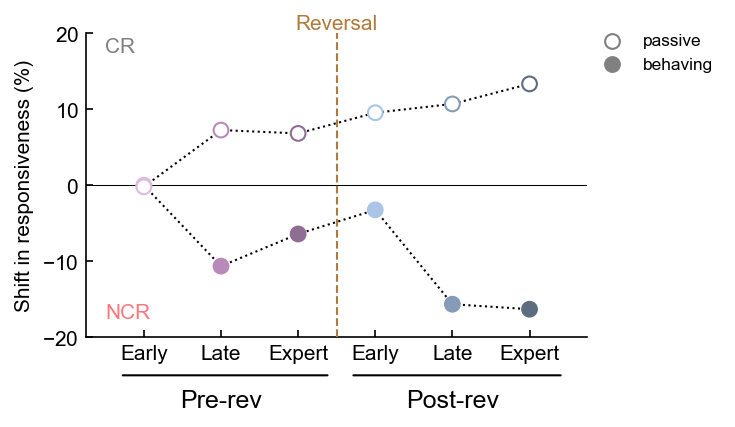

In [90]:
fig, ax = plt.subplots(figsize=(5,3))
labels = ['Early','Late','Expert','Early','Late','Expert']
#colors = phase_colors = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']

percentCR = np.array([FRmod_preearly_pc,FRmod_prelate_pc,FRmod_preexpert_pc,FRmod_postearly_pc,FRmod_postlate_pc,FRmod_postexpert_pc])*100
numCon = len(labels)
ax.plot([0,1,2,3,4,5],(percentCR-50),color='k',linestyle=':',lw=1,alpha=1)

color=NCR_CR_cmap((percentCR-40)/20)
ax.scatter([0,1,2,3,4,5],(percentCR-50),c=PHASE_COLORS,s=50,zorder=10,marker='o',lw=1)


percentCR = np.array([FRmod_passive_preearly_pc,FRmod_passive_prelate_pc,FRmod_passive_preexpert_pc,FRmod_passive_postearly_pc,FRmod_passive_postlate_pc,FRmod_passive_postexpert_pc])*100
ax.plot([0,1,2,3,4,5],(percentCR-50),color='k',linestyle=':',lw=1,alpha=1)

color=NCR_CR_cmap((percentCR-40)/20)
ax.scatter(range(numCon),(percentCR-50),fc='white',ec=PHASE_COLORS,s=50,zorder=10,marker='o',lw=1)





xlims = [-0.75,numCon-0.25]
ax.set_xlim(xlims)
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)

#All cells with All Cells baseline
ax.set_ylabel('Shift in responsiveness (%)')
ax.set_ylim([-20,20])
ax.set_yticks([-20,-10,0,10,20])
ax.text(-0.5,17.5,'CR',color=CR_COLOR)
ax.text(-0.5,-17.5,'NCR',color=NCR_COLOR)

ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

#ax.plot([2.5,2.5],ax.get_ylim(),color='blue',lw=1,zorder=-15)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
ax.axhline(0,c='k',linestyle='-',lw=0.5,zorder=-10)

ax.scatter([],[],fc='white',ec='grey',s=50,marker='o',lw=1,label='passive')
ax.scatter([],[],fc='grey',ec='grey',s=50,marker='o',lw=1,label='behaving')
ax.legend(frameon=False,loc=(1,0.85))



xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
rev_title_y_pos = 0.17 * (ax.get_ylim()[1] - ax.get_ylim()[0])
ax.text(xtick_pos_pre, ax.get_ylim()[0]-rev_title_y_pos, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, ax.get_ylim()[0]-rev_title_y_pos, 'Post-rev', ha='center', va='top',  fontsize=12)
y_val = -0.125
ax.annotate('', xy=(0.065, y_val), xycoords='axes fraction', xytext=(0.49, y_val),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.525, y_val), xycoords='axes fraction', xytext=(0.955, y_val),arrowprops=dict(arrowstyle='-', color='black'))

plt.tight_layout()
plt.savefig(os.path.join('D:\\\\Figures','Decoding Figures','Shift in responsiveness','AC Shift in responsiveness all cells vs passive larger scale.pdf'),transparent=False,facecolor="white")